# Optimization problems for increased calcium carbonate production

### Import packages and load data

In [1]:
import os
import json
import sympy
import torch
import simplesbml 
import math
import libsbml
import requests
import numpy as np
import pandas as pd
import tellurium as te
import antimony as at
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
import mira
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.sources.sbml import template_model_from_sbml_file
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
)

### simulating data

In [2]:
smetana_carbstor_sbml_file = './smetana_carbstor_consumer_resource_corrected.xml'
rr_model = te.loadSBMLModel(smetana_carbstor_sbml_file)

all_species = rr_model.getFloatingSpeciesIds()
species_wo_metabolites = [s for s in all_species if not s.startswith('M')]

print(f'The model contains {len(species_wo_metabolites)} donor and receiver species and {len(all_species)-len(species_wo_metabolites)} metabolite compounds.')


The model contains 5 donor and receiver species and 27 metabolite compounds.


In [ ]:
def create_custom_time_vector(num_points_initial, num_points_steady, t_initial_end=100, t_total_end=500):
    """Create a custom time vector with specified number of points"""
    initial_phase = np.linspace(0, t_initial_end, num_points_initial, endpoint=False)
    steady_phase = np.linspace(t_initial_end, t_total_end, num_points_steady)
    time_vector = np.concatenate((initial_phase, steady_phase))
    return time_vector


time_points_6 = create_custom_time_vector(3, 3, 50, 500)
time_points_12 = create_custom_time_vector(6, 6, 50, 500)
time_points_9 = create_custom_time_vector(6, 3, 50, 500)

print(f"Time vector with 6 points: {time_points_6}")
print(f"Time vector with 12 points: {time_points_12}")
print(f"Time vector with 12 points: {time_points_9}")

In [ ]:

# simulate and plot
results1 = rr_model.simulate(times=time_points_6)
rr_model.plot(title='6 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

results2 = rr_model.simulate(times=time_points_12)
rr_model.plot(title='12 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

results3 = rr_model.simulate(times=time_points_9)
rr_model.plot(title='9 datapoints: all species concentration vs time', figsize=(15, 8))
rr_model.resetToOrigin()

In [ ]:

def format_and_save_road_runner_results(fname, rr_results, obs_mets=True):
    formatted_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
    if not obs_mets:
        formatted_df = formatted_df.loc[:, ~formatted_df.columns.str.startswith('[M')]
    formatted_df = formatted_df.set_index('time')
    formatted_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss
    formatted_df.to_csv(fname)
    return formatted_df

In [ ]:
# all observations (incl. metabolites), 6 time points
all_obs_6_measurements_data_file_path = 'simulated_data_w_mets_6_measurements.csv'
all_obs_6_measurements = format_and_save_road_runner_results(all_obs_6_measurements_data_file_path,results1, obs_mets=True )
all_obs_6_measurements.head()

In [ ]:
# no metabolite observations, 6 time points
no_mets_6_measurements_data_file_path = 'simulated_data_no_mets_6_measurements.csv'
no_mets_6_measurements = format_and_save_road_runner_results(no_mets_6_measurements_data_file_path, results1, obs_mets=False)
no_mets_6_measurements.head()


In [ ]:
# all observations (incl. metabolites), 12 time points
all_obs_12_measurements_data_file_path = 'simulated_data_w_mets_12_measurements.csv'
all_obs_12_measurements = format_and_save_road_runner_results(all_obs_12_measurements_data_file_path, results2, obs_mets=True)
all_obs_12_measurements.head()

In [ ]:
# no metabolite observations, 12 time points
no_mets_12_measurements_data_file_path = 'simulated_data_no_mets_12_measurements.csv'
no_mets_12_measurements = format_and_save_road_runner_results(no_mets_12_measurements_data_file_path, results2, obs_mets=False)
no_mets_12_measurements.head()

In [ ]:
# all observations (incl. metabolites), 9 time points
all_obs_9_measurements_data_file_path = 'simulated_data_w_mets_9_measurements.csv'
all_obs_9_measurements = format_and_save_road_runner_results(all_obs_9_measurements_data_file_path,results3, obs_mets=True )
all_obs_9_measurements.head()

In [ ]:
# no metabolites measured, 9 time points
no_mets_9_measurements_data_file_path = 'simulated_data_no_mets_9_measurements.csv'
no_mets_9_measurements = format_and_save_road_runner_results(no_mets_9_measurements_data_file_path,results3, obs_mets=False )
no_mets_9_measurements.head()

### calibration

- assign priors (if needed)
- save as AMRPetriNet (JSON) file
- run calibration

In [ ]:
smetana_carbstor_mira_model = template_model_from_sbml_file(smetana_carbstor_sbml_file)

## for priors use uniform(0,1)

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.0,"maximum": 1.0 }     
                     )

for name,parameter in smetana_carbstor_mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist

parameter

In [ ]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model

model_json_file_name = 'smetana_carbstor_mira_model_w_priors.json'
 
pm = AMRPetriNetModel(Model(smetana_carbstor_mira_model))
pm.to_json_file(
            model_json_file_name,
            name='smetana_carbstor_mira_model_w_priors',
            description="smetana_carbstor_mira_model_w_priors",
            indent=2,
        )



In [ ]:
num_iterations = 100
data_to_use = no_mets_9_measurements
data_path = no_mets_9_measurements_data_file_path
model_path_or_json = model_json_file_name

data_mapping = {k:k.strip("[]") for k in data_to_use.columns}  # remove '[]' for concentration added by Tellurium
calibration_results = pyciemss.calibrate(model_path_or_json, data_path, data_mapping=data_mapping, num_iterations=num_iterations, verbose=True)

In [ ]:
calibration_results

In [ ]:
parameter_estimates = calibration_results["inferred_parameters"]
parameter_estimates()

In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1	#1.0
num_samples = 100

calibrated_sample_results = pyciemss.sample(smetana_carbstor_mira_model, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())


In [ ]:
calibrated_sample_results.keys()
calibrated_sample_results['unprocessed_result'].keys()

In [ ]:
# Plot results for all states
schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# get ground truths (for simulated data)
import json
# Load the JSON file
with open(model_path_or_json, 'r') as f:
    json_data = json.load(f)

# Extract the parameter ground truth values
parameters_info = json_data['semantics']['ode']['parameters']
ground_truth = {param['id']: param['value'] for param in parameters_info}

# Function to clean parameter names by removing "persistent_" prefix
def clean_param_name(param_name):
    return param_name.replace("persistent_", "")

ground_truth

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Extract the unprocessed results (parameter estimates)
unprocessed_result = calibrated_sample_results['unprocessed_result']

# Isolate only 1-dimensional tensors (parameters) and clean parameter names
parameters_data = {clean_param_name(k): v.numpy() for k, v in unprocessed_result.items() if v.ndim == 1}

if not parameters_data:
    print("No parameters found in the unprocessed results.")
else:
    # Convert to Pandas DataFrame
    parameters_df = pd.DataFrame(parameters_data)
    
    if parameters_df.empty:
        print("The parameters DataFrame is empty.")
    else:
        # Plotting in multiple subplots to avoid overcrowding
        num_parameters = len(parameters_df.columns)
        num_rows = math.ceil(num_parameters / 5)  # Adjust the number of columns per row
        fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, num_rows * 5), sharex=True)
        
        # Flatten the axes for easy indexing
        axes = axes.flatten()
        
        for i, column in enumerate(parameters_df.columns):
            sns.kdeplot(parameters_df[column], ax=axes[i], fill=True)
            # Plotting the ground truth value as a vertical line
            if column in ground_truth:
                axes[i].axvline(ground_truth[column], color='red', linestyle='--', label=f'Ground Truth: {ground_truth[column]}')
                axes[i].legend()
            axes[i].set_title(column)
        
        # Hide any unused subplots
        for i in range(num_parameters, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()



In [ ]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 500.0
logging_step_size = 1	#1.0
num_samples = 100

prior_predictive_sample_results = pyciemss.sample(smetana_carbstor_mira_model, end_time, logging_step_size, num_samples, 
                start_time=start_time)
display(prior_predictive_sample_results["data"].head())

In [ ]:
# Plot results for all states
schema = plots.trajectories(prior_predictive_sample_results["data"], keep=".*_state")
#plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)




# Model for calcium carbonate ($\mathrm{CaCO_3}$) precipitation

ref: https://www.mdpi.com/2076-3417/14/7/2854 (eqns 1-6)

see also: https://pubmed.ncbi.nlm.nih.gov/1857197/, https://pubmed.ncbi.nlm.nih.gov/1857197/ (for enzymatic reactions)

## Calculation of Molarity of Calcium in Solution

### Problem Statement:
To find the molarity (mol/L) of calcium in a solution where 20 grams of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ is dissolved in 1 liter of water.

### Step-by-Step Calculation:

1. **Molar Mass of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$**:
   - Calculate the molar mass of calcium chloride dihydrate:
     - Calcium (Ca): $1 \times 40.08 \, \text{g/mol} = 40.08 \, \text{g/mol}$
     - Chlorine (Cl): $2 \times 35.45 \, \text{g/mol} = 70.90 \, \text{g/mol}$
     - Water (H₂O): $2 \times 18.02 \, \text{g/mol} = 36.04 \, \text{g/mol}$
     - Total molar mass: $40.08 + 70.90 + 36.04 = 147.02 \, \text{g/mol}$

2. **Convert Grams to Moles**:
   - Use the molar mass to convert the mass of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ to moles:
     $$
     \text{moles of } \text{CaCl}_2 \cdot 2\text{H}_2\text{O} = \frac{20 \, \text{g}}{147.02 \, \text{g/mol}} \approx 0.136 \, \text{mol}
     $$

3. **Determine Molarity of Calcium**:
   - Since the solution volume is 1 liter, the molarity of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ is:
     $$
     \text{Molarity of } \text{CaCl}_2 \cdot 2\text{H}_2\text{O} = \frac{0.136 \, \text{mol}}{1 \, \text{L}} = 0.136 \, \text{M}
     $$

4. **Calcium Ion Contribution**:
   - Each formula unit of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$ dissociates to give 1 calcium ion ($\text{Ca}^{2+}$) and 2 chloride ions ($\text{Cl}^-$) in solution.
   - Therefore, the molarity of calcium ions ($\text{Ca}^{2+}$) is the same as the molarity of $\text{CaCl}_2 \cdot 2\text{H}_2\text{O}$:
     $$
     \text{Molarity of } \text{Ca}^{2+} = 0.136 \, \text{M}
     $$

### Conclusion:

The molarity of calcium ($\text{Ca}^{2+}$) in the solution is $0.136 \, \text{M}$.



2% CaCl2-2H2O	20 g

## Calculation of Molarity of Urea in Solution

### Problem Statement:
To find the molarity (mol/L) of urea ($\text{CO(NH}_2\text{)}_2$) in a solution where 20 grams of urea is dissolved in 1 liter of water.

### Step-by-Step Calculation:

1. **Molar Mass of Urea**:
   - Calculate the molar mass of urea:
     - Carbon (C): $1 \times 12.01 \, \text{g/mol} = 12.01 \, \text{g/mol}$
     - Oxygen (O): $1 \times 16.00 \, \text{g/mol} = 16.00 \, \text{g/mol}$
     - Nitrogen (N): $2 \times 14.01 \, \text{g/mol} = 28.02 \, \text{g/mol}$
     - Hydrogen (H): $4 \times 1.01 \, \text{g/mol} = 4.04 \, \text{g/mol}$
     - Total molar mass: $12.01 + 16.00 + 28.02 + 4.04 = 60.07 \, \text{g/mol}$

2. **Convert Grams to Moles**:
   - Use the molar mass to convert the mass of urea to moles:
     $$
     \text{moles of urea} = \frac{20 \, \text{g}}{60.07 \, \text{g/mol}} \approx 0.333 \, \text{mol}
     $$

3. **Determine Molarity**:
   - Since the solution volume is 1 liter, the molarity of urea is:
     $$
     \text{Molarity of urea} = \frac{0.333 \, \text{mol}}{1 \, \text{L}} = 0.333 \, \text{M}
     $$

### Conclusion:

The molarity of urea ($\text{CO(NH}_2\text{)}_2$) in the solution is $0.333 \, \text{M}$.

## Calculation of Atmospheric Carbon Dioxide Concentration in Moles per Liter

### Problem Statement:
To find the concentration of atmospheric carbon dioxide ($\text{CO}_2$) in moles per liter (molarity).

### Step-by-Step Calculation:

1. **Partial Pressure of $\text{CO}_2$**:
   - Atmospheric $\text{CO}_2$ concentration is typically around 400 parts per million (ppm).
   - This means that $\text{CO}_2$ constitutes $0.04\%$ of the total atmospheric pressure.
   - Assuming standard atmospheric pressure is 1 atmosphere (atm), the partial pressure of $\text{CO}_2$ is:
     $$
     P_{\text{CO}_2} = 0.04\% \times 1 \, \text{atm} = 0.0004 \, \text{atm}
     $$

2. **Ideal Gas Law**:
   - The ideal gas law is given by:
     $$
     PV = nRT
     $$
   - Where:
     - $P$ = pressure in atm
     - $V$ = volume in liters
     - $n$ = number of moles
     - $R$ = ideal gas constant $= 0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)$
     - $T$ = temperature in Kelvin (K)
   - Rearranging to solve for molarity (moles per liter):
     $$
     \frac{n}{V} = \frac{P}{RT}
     $$

3. **Assumptions**:
   - Standard temperature $T = 298 \, \text{K}$ (25°C)

4. **Calculation**:
   - Using the values:
     $$
     P_{\text{CO}_2} = 0.0004 \, \text{atm}
     $$
     $$
     R = 0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)
     $$
     $$
     T = 298 \, \text{K}
     $$
   - Plugging in these values:
     $$
     \frac{n}{V} = \frac{0.0004 \, \text{atm}}{0.0821 \, \text{L} \cdot \text{atm}/(K\cdot mol)} \times 298 \, \text{K}
     $$
     $$
     \frac{n}{V} = \frac{0.0004}{24.45} \, \text{mol/L}
     $$
     $$
     \frac{n}{V} \approx 1.64 \times 10^{-5} \, \text{mol/L}
     $$

### Conclusion:

The concentration of atmospheric carbon dioxide is approximately $1.64 \times 10^{-5}$ moles per liter (M).
 

In [ ]:
# rr_model = te.loada(antimony_fname)

# print(rr_model.getFloatingSpeciesIds())
# print(rr_model.getGlobalParameterIds())
# selections = list(rr_model.getFloatingSpeciesIds()) + list(rr_model.getGlobalParameterIds())

#rr_results = rr_model.simulate(0,100,100, selections=selections)
rr_results = rr_model.simulate(0,0.001,100)
rr_model.plot(figsize=(12,8))
rr_model.resetToOrigin()

### update SBML model species names, initial concentatrations

In [ ]:
corrected_sbml_file = 'smetana_carbstor_consumer_resource_corrected2.xml'

d = libsbml.readSBMLFromFile(sbml_file)
m = d.getModel()
# for initial in m.getListOfInitialAssignments():
#     print(initial)

for species in m.getListOfSpecies():
    species.name = species.id
    species.initial_concentration = species.initial_amount
    species.has_only_substance_units = False

libsbml.writeSBMLToFile(d,corrected_sbml_file)

### load corrected model as MIRA model and add priors

In [ ]:
mira_model = template_model_from_sbml_file(corrected_sbml_file)

mira_model

In [ ]:
## for priors use uniform(0,1)

from mira.metamodel import Distribution


rate_constant_dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 1e-3,"maximum": 1.0 }     
                     )

for name,parameter in mira_model.parameters.items():
    if name.startswith('k'): # only assign priors for rate constants
        parameter.distribution = rate_constant_dist
    print(name, parameter, parameter.distribution)


In [ ]:
mira_model.initials

In [ ]:
mira_model

In [ ]:
start_time = 0.0
end_time = 10.0
logging_step_size = 1
num_samples = 10

petrinet_results = pyciemss.sample(mira_model, end_time, logging_step_size, num_samples, start_time=start_time)

### create petri net model

In [ ]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model

model_json_file_name = 'microbial_induced_calcium_carbonate_precipitation_petri_net_model.json'
 
petrinet_model = AMRPetriNetModel(Model(mira_model))


petrinet_model.to_json_file(
            model_json_file_name,
            name='microbial_induced_calcium_carbonate_precipitation_petri_net_model',
            description="microbial_induced_calcium_carbonate_precipitation_petri_net_model",
            indent=2,
        )



### simulate petri net model

In [ ]:
start_time = 0.0
end_time = 1.0
logging_step_size = 0.01
num_samples = 10

petrinet_results = pyciemss.sample(mira_model, end_time, logging_step_size, num_samples, start_time=start_time)
# petrinet_results = pyciemss.sample(model_json_file_name, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())
print(petrinet_results.keys())


Setup

# Load and simulate model

### Load and simulate antimony model

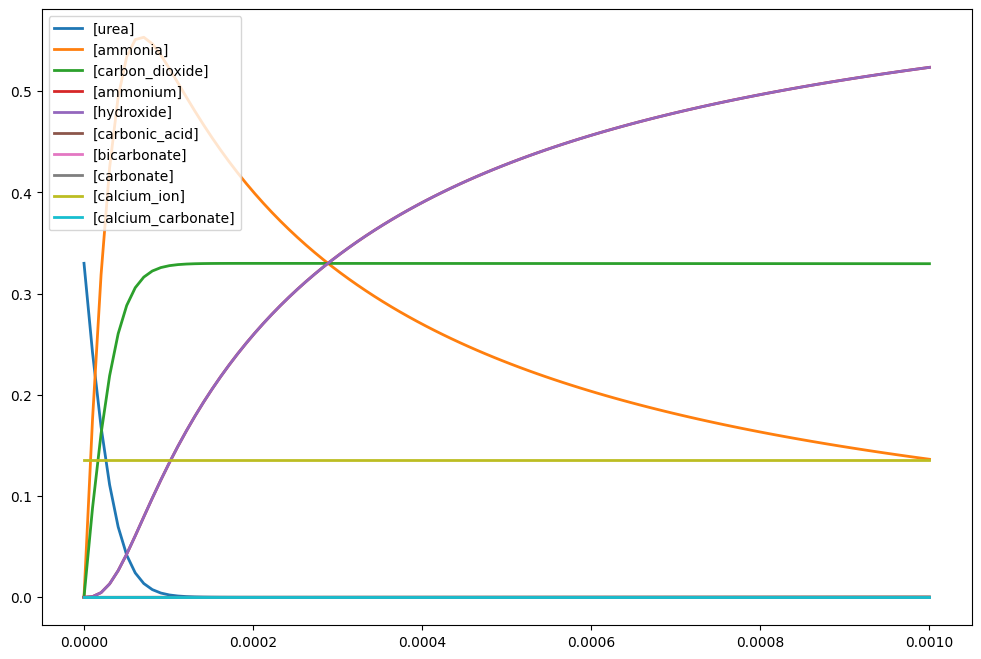

In [3]:
# Load antimony model
antimony_model_url = ('https://raw.githubusercontent.com/pnnl-predictive-phenomics/concerto/'
             '7-consumer-resource-model-based-on-smetana-initial-outputs/'
             'concerto/notebooks/consumer_resource_modeling/'
             'microbial_induced_calcium_carbonate_precipitation_model.txt')

antimony_model = requests.get(antimony_model_url).text
a_model = te.loada(antimony_model)

# Simulate antimony model
a_results = a_model.simulate(0,0.001,100)
a_model.plot(figsize=(12,8))
a_model.resetToOrigin()

### Change model format and correct initials and parameter distributions

In [4]:
# Export to SBML
sbml_model_name = "microbial_induced_calcium_carbonate_precipitation_model.xml"
corrected_sbml_model = 'microbial_induced_calcium_carbonate_precipitation_model_corrected.xml'
a_model.exportToSBML(sbml_model_name)

# Correct initial conditions
d = libsbml.readSBMLFromFile(sbml_model_name)
m = d.getModel()
for species in m.getListOfSpecies():
    species.name = species.id
    # print(species.name, species.initial_concentration)
    if math.isnan(species.initial_concentration):
        species.initial_concentration = species.initial_amount
    else:
        print(species.name, species.initial_concentration)
    species.has_only_substance_units = False
    # print(species)

# Save corrected SBML 
libsbml.writeSBMLToFile(d, corrected_sbml_model)

# Convert from corrected SMBL to MIRA template model
tm = template_model_from_sbml_file(corrected_sbml_model)

# Impose a distribution on rate constants only (k-parameters)
rate_constant_dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 1e-3,"maximum": 1.0 }     
                     )

for name,parameter in tm.parameters.items():
    if name.startswith('k'): # only assign priors for rate constants
        parameter.distribution = rate_constant_dist
    # print(name, parameter, parameter.distribution)

# print(tm)

# Save template model as a petrinet AMR
model_name = "microbial_induced_calcium_carbonate_precipitation_model.json"
with open(model_name, 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)

water 55.0


### Set parameters for sampling

In [5]:
num_samples = 100
start_time = 0.0
end_time = 0.001
logging_step_size = 0.00001

### Sample from the model and plot the results

,timepoint_id,sample_id,timepoint_unknown,persistent_k2f_param,persistent_k2r_param,persistent_k4f_param,persistent_k4r_param,persistent_k5f_param,persistent_k5r_param,persistent_k6f_param,...,ammonia_state,carbon_dioxide_state,water_state,ammonium_state,hydroxide_state,carbonic_acid_state,bicarbonate_state,carbonate_state,calcium_carbonate_state,calcium_ion_state
0,0,0,0.0,0.235661,0.104255,0.055894,0.244942,0.783007,0.898047,0.602864,...,0.000010,0.000010,55.000000,0.000010,1.000000e-07,0.000010,0.00001,0.00001,0.000000e+00,0.136
1,1,0,0.00001,0.235661,0.104255,0.055894,0.244942,0.783007,0.898047,0.602864,...,0.160242,0.160375,54.839504,0.000143,1.333148e-04,0.000012,0.00001,0.00001,1.638968e-11,0.136
2,2,0,0.00002,0.235661,0.104255,0.055894,0.244942,0.783007,0.898047,0.602864,...,0.258230,0.259021,54.740189,0.000805,7.948845e-04,0.000017,0.00001,0.00001,3.276296e-11,0.136
3,3,0,0.00003,0.235661,0.104255,0.055894,0.244942,0.783007,0.898047,0.602864,...,0.303146,0.305075,54.692970,0.001946,1.936454e-03,0.000024,0.00001,0.00001,4.911991e-11,0.136
4,4,0,0.00004,0.235661,0.104255,0.055894,0.244942,0.783007,0.898047,0.602864,...,0.318752,0.322054,54.674625,0.003323,3.312763e-03,0.000032,0.00001,0.00001,6.546050e-11,0.136


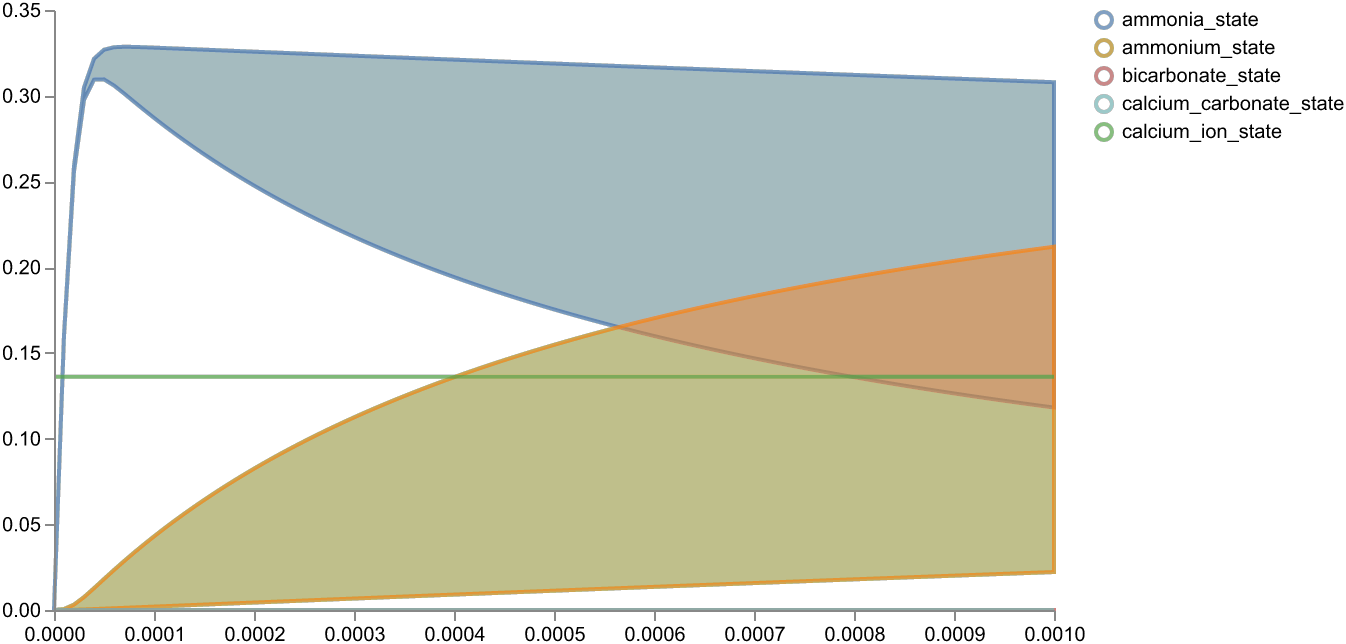

In [9]:
result1 = pyciemss.sample(model_name, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

schema = plots.trajectories(
    result1["data"], 
    keep=["ammonia_state", "ammonium_state", "bicarbonate_state", "calcium_carbonate_state", "calcium_ion_state", 
         # "carbon_dioxide_state", "carbonate_state", "carbonic_acid_state", "hydroxide_state", "urea_state"
         ],
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

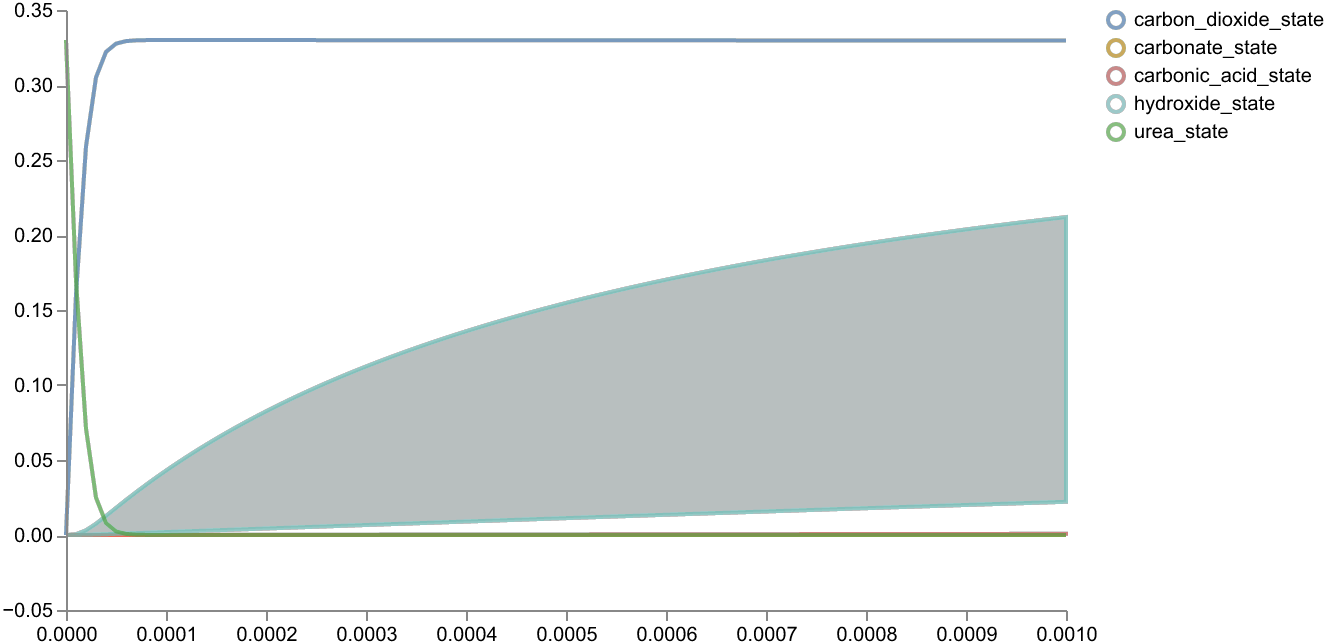

In [10]:
schema = plots.trajectories(
    result1["data"], 
    keep=["carbon_dioxide_state", "carbonate_state", "carbonic_acid_state", "hydroxide_state", "urea_state"],
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Change initial conditions and sample

# Optimization

### Set up the optimization problem

### Perform optimization

### Sample from the model with optimized interventions